In [1]:
!pip install ultralytics

import os
import shutil
import matplotlib.pyplot as plt
import cv2
import random
from IPython.display import Image, display
import pandas as pd
import seaborn as sns
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 15.8 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
!pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! mkdir ~/.kaggle

In [4]:
!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/kaggle.json

In [5]:

! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download sukmaadhiwijaya/welding-defect-object-detection --force

Dataset URL: https://www.kaggle.com/datasets/sukmaadhiwijaya/welding-defect-object-detection
License(s): CC0-1.0
 98% 150M/152M [00:01<00:00, 109MB/s]
100% 152M/152M [00:01<00:00, 109MB/s]


In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sukmaadhiwijaya/welding-defect-object-detection")

print("Path to dataset files:", path)

100%|██████████| 152M/152M [00:01<00:00, 81.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/sukmaadhiwijaya/welding-defect-object-detection/versions/2


In [7]:
curl -L -o ~/Downloads/welding-defect-object-detection.zip\
  https://www.kaggle.com/api/v1/datasets/download/sukmaadhiwijaya/welding-defect-object-detection

SyntaxError: invalid syntax (<ipython-input-7-d4717c497efc>, line 1)

In [7]:
# Define paths
root_dir = path
v1_dir = os.path.join(root_dir, 'The Welding Defect Dataset/The Welding Defect Dataset')
v2_dir = os.path.join(root_dir, 'The Welding Defect Dataset - v2/The Welding Defect Dataset - v2')

In [8]:
# Ensure the YOLOv8 data directories exist
os.makedirs('yolov8/data/welding_v1', exist_ok=True)
os.makedirs('yolov8/data/welding_v2', exist_ok=True)

Displaying some training images from version 1:


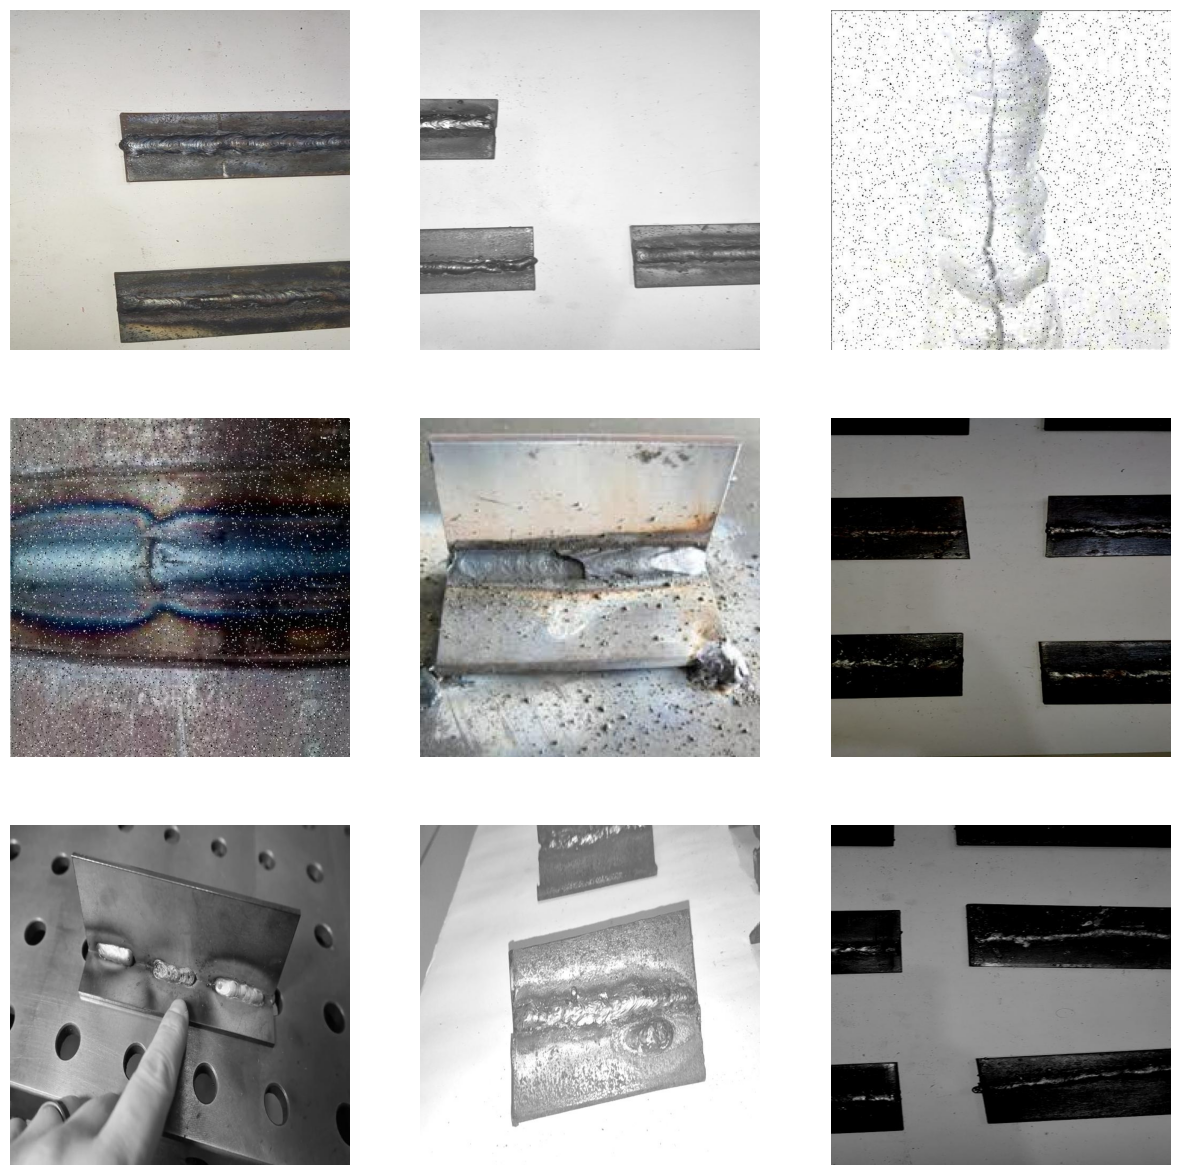

Displaying some training images from version 2:


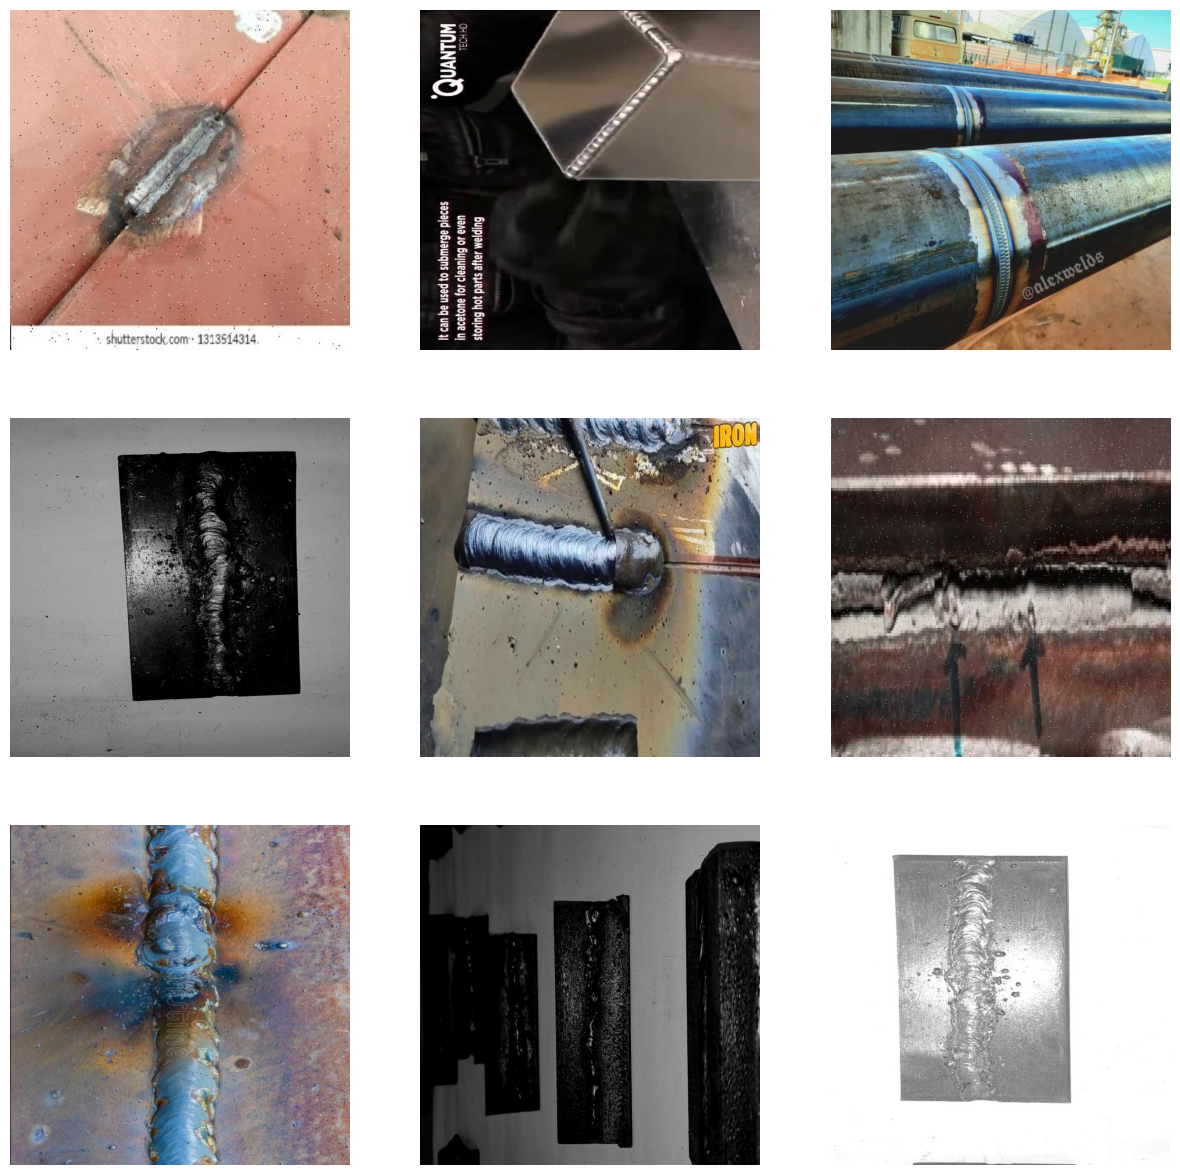

In [9]:
# Function to display images
def display_images(image_dir, num_images=9):
    images = os.listdir(image_dir)
    sample_images = random.sample(images, num_images)
    plt.figure(figsize=(15, 15))
    for i, image_name in enumerate(sample_images):
        image_path = os.path.join(image_dir, image_name)
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(3, 3, i + 1)
        plt.imshow(img_rgb)
        plt.axis('off')
    plt.show()

# Display some training images
print("Displaying some training images from version 1:")
display_images(os.path.join(v1_dir, 'train/images'))

print("Displaying some training images from version 2:")
display_images(os.path.join(v2_dir, 'train/images'))

In [10]:
# Copy dataset to YOLOv8 directory
def copy_dataset_to_yolo(src_dir, dest_dir):
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)
    shutil.copytree(src_dir, dest_dir)

# Copy version 1 dataset
copy_dataset_to_yolo(v1_dir, '/content/yolov8/data/welding_v1')

# Copy version 2 dataset
copy_dataset_to_yolo(v2_dir, '/content/yolov8/data/welding_v2')

In [11]:
# Update data.yaml paths
def update_data_yaml(data_yaml_path, base_dir):
    with open(data_yaml_path, 'r') as file:
        data_yaml = file.read()
    data_yaml = data_yaml.replace('../train/images', os.path.join(base_dir, 'train/images'))
    data_yaml = data_yaml.replace('../valid/images', os.path.join(base_dir, 'valid/images'))
    data_yaml = data_yaml.replace('../test/images', os.path.join(base_dir, 'test/images'))
    with open(data_yaml_path, 'w') as file:
        file.write(data_yaml)

# Update data.yaml for version 1
update_data_yaml('yolov8/data/welding_v1/data.yaml', '/content/yolov8/data/welding_v1')

# Update data.yaml for version 2
update_data_yaml('yolov8/data/welding_v2/data.yaml', '/content/yolov8/data/welding_v2')

# Print and verify updated data.yaml files
def print_data_yaml(data_yaml_path):
    with open(data_yaml_path, 'r') as file:
        print(file.read())

print("Updated data.yaml for version 1:")
print_data_yaml('yolov8/data/welding_v1/data.yaml')

print("Updated data.yaml for version 2:")
print_data_yaml('yolov8/data/welding_v2/data.yaml')

Updated data.yaml for version 1:
train: /content/yolov8/data/welding_v1/train/images
val: /content/yolov8/data/welding_v1/valid/images
test: /content/yolov8/data/welding_v1/test/images

nc: 3
names: ['Bad Weld', 'Good Weld', 'Defect']


Updated data.yaml for version 2:
train: /content/yolov8/data/welding_v2/train/images
val: /content/yolov8/data/welding_v2/valid/images
test: /content/yolov8/data/welding_v2/test/images

nc: 3
names: ['Bad Weld', 'Good Weld', 'Defect']




In [12]:
# EDA and Preprocessing
def load_labels(label_dir):
    label_files = os.listdir(label_dir)
    data = []
    for label_file in label_files:
        with open(os.path.join(label_dir, label_file), 'r') as file:
            lines = file.readlines()
            for line in lines:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                data.append([label_file, class_id, x_center, y_center, width, height])
    df = pd.DataFrame(data, columns=['file', 'class_id', 'x_center', 'y_center', 'width', 'height'])
    return df

v1_train_labels = load_labels(os.path.join(v1_dir, 'train/labels'))
v2_train_labels = load_labels(os.path.join(v2_dir, 'train/labels'))

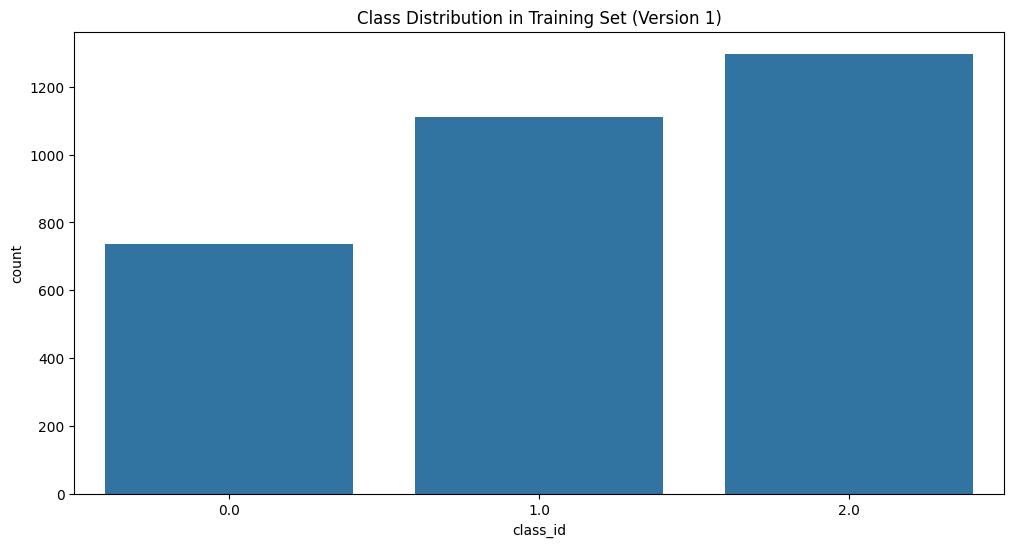

In [13]:
# Plot class distribution
plt.figure(figsize=(12, 6))
sns.countplot(data=v1_train_labels, x='class_id')
plt.title('Class Distribution in Training Set (Version 1)')
plt.show()

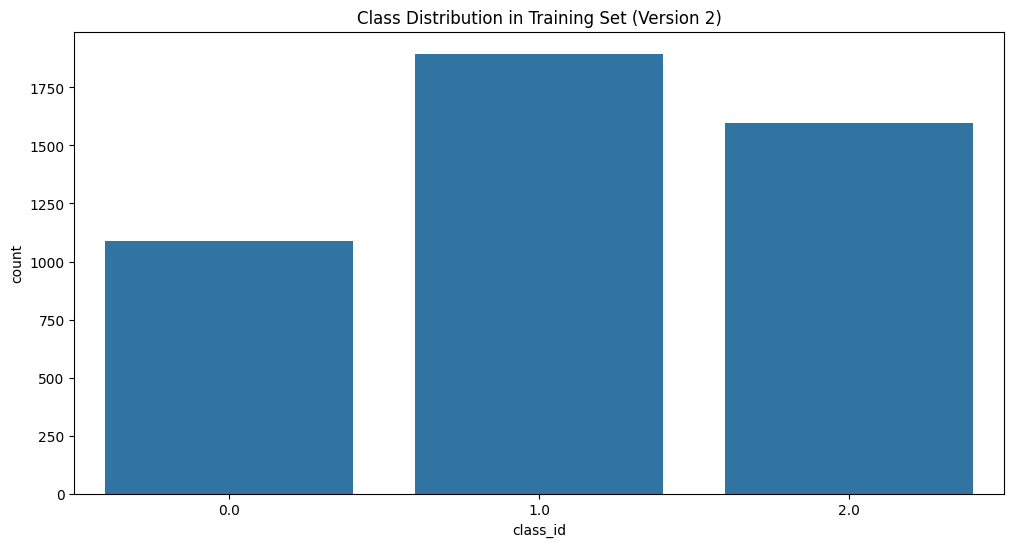

In [14]:
plt.figure(figsize=(12, 6))
sns.countplot(data=v2_train_labels, x='class_id')
plt.title('Class Distribution in Training Set (Version 2)')
plt.show()

In [15]:
# Train YOLOv8 model with augmentation and hyperparameter tuning
# Initialize model
model_v1 = YOLO('yolov8m.pt')  # YOLOv8m (medium) model
model_v2 = YOLO('yolov8m.pt')  # YOLOv8m (medium) model

100%|██████████| 49.7M/49.7M [00:00<00:00, 239MB/s]


Found existing installation: ultralytics 8.0.20
Uninstalling ultralytics-8.0.20:
  Would remove:
    /usr/local/bin/ultralytics
    /usr/local/bin/yolo
    /usr/local/lib/python3.10/dist-packages/ultralytics-8.0.20.dist-info/*
    /usr/local/lib/python3.10/dist-packages/ultralytics/*
Proceed (Y/n)? y
  Successfully uninstalled ultralytics-8.0.20


In [16]:
# Train model on version 1 dataset
model_v1.train(data='/content/yolov8/data/welding_v1/data.yaml', epochs=1, imgsz=640, batch=16, name='welding_v1_aug',
               lr0=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1,
               box=0.05, cls=0.5, iou=0.2, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, translate=0.1, scale=0.5, mosaic=1.0, mixup=0.5)

# Train model on version 2 dataset
model_v2.train(data='/content/yolov8/data/welding_v2/data.yaml', epochs=1, imgsz=640, batch=16, name='welding_v2_aug',
               lr0=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1,
               box=0.05, cls=0.5, iou=0.2, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, translate=0.1, scale=0.5, mosaic=1.0, mixup=0.5)

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/yolov8/data/welding_v1/data.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=welding_v1_aug, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.2, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sho

100%|██████████| 755k/755k [00:00<00:00, 14.6MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 67.1MB/s]


AMP: checks passed ✅


train: Scanning /content/yolov8/data/welding_v1/train/labels... 839 images, 0 backgrounds, 0 corrupt: 100%|██████████| 839/839 [00:00<00:00, 1890.94it/s]

train: New cache created: /content/yolov8/data/welding_v1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/yolov8/data/welding_v1/valid/labels... 176 images, 0 backgrounds, 0 corrupt: 100%|██████████| 176/176 [00:00<00:00, 1099.22it/s]

val: New cache created: /content/yolov8/data/welding_v1/valid/labels.cache


Plotting labels to runs/detect/welding_v1_aug/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/welding_v1_aug
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      6.91G     0.0143      2.799      1.826         52        640: 100%|██████████| 53/53 [00:35<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


                   all        176        573      0.261      0.403      0.208     0.0824

1 epochs completed in 0.014 hours.
Optimizer stripped from runs/detect/welding_v1_aug/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/welding_v1_aug/weights/best.pt, 52.0MB

Validating runs/detect/welding_v1_aug/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]


                   all        176        573      0.262      0.403      0.208     0.0821
              Bad Weld         87        127       0.18      0.567      0.153      0.053
             Good Weld        119        253       0.44      0.581      0.423       0.18
                Defect         90        193      0.165     0.0613     0.0478     0.0128
Speed: 0.4ms preprocess, 9.1ms inference, 0.0ms loss, 7.6ms postprocess per image
Results saved to runs/detect/welding_v1_aug
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/yolov8/data/welding_v2/data.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=welding_v2_aug, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True

train: Scanning /content/yolov8/data/welding_v2/train/labels... 1619 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1619/1619 [00:00<00:00, 1913.12it/s]

train: New cache created: /content/yolov8/data/welding_v2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/yolov8/data/welding_v2/valid/labels... 283 images, 0 backgrounds, 0 corrupt: 100%|██████████| 283/283 [00:00<00:00, 755.58it/s]

val: New cache created: /content/yolov8/data/welding_v2/valid/labels.cache


Plotting labels to runs/detect/welding_v2_aug/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/welding_v2_aug
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      7.34G    0.01393       2.71      1.889         22        640: 100%|██████████| 102/102 [01:00<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:08<00:00,  1.04it/s]


                   all        283        802      0.509      0.144      0.124     0.0478

1 epochs completed in 0.022 hours.
Optimizer stripped from runs/detect/welding_v2_aug/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/welding_v2_aug/weights/best.pt, 52.0MB

Validating runs/detect/welding_v2_aug/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25,841,497 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


                   all        283        802      0.511      0.143      0.124     0.0478
              Bad Weld        141        194      0.213     0.0309     0.0971     0.0405
             Good Weld        175        335       0.32      0.397      0.266      0.101
                Defect        128        273          1          0    0.00774    0.00216
Speed: 0.3ms preprocess, 10.1ms inference, 0.0ms loss, 8.9ms postprocess per image
Results saved to runs/detect/welding_v2_aug


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a0ca0aeba90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

Displaying results from model trained on version 1 with augmentation:

image 1/1 /root/.cache/kagglehub/datasets/sukmaadhiwijaya/welding-defect-object-detection/versions/2/The Welding Defect Dataset/The Welding Defect Dataset/test/images/good-tig-welds_32_png_jpg.rf.31e47557dc8768f6a9dd99627ca3a6e7.jpg: 640x640 (no detections), 37.1ms
Speed: 1.9ms preprocess, 37.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


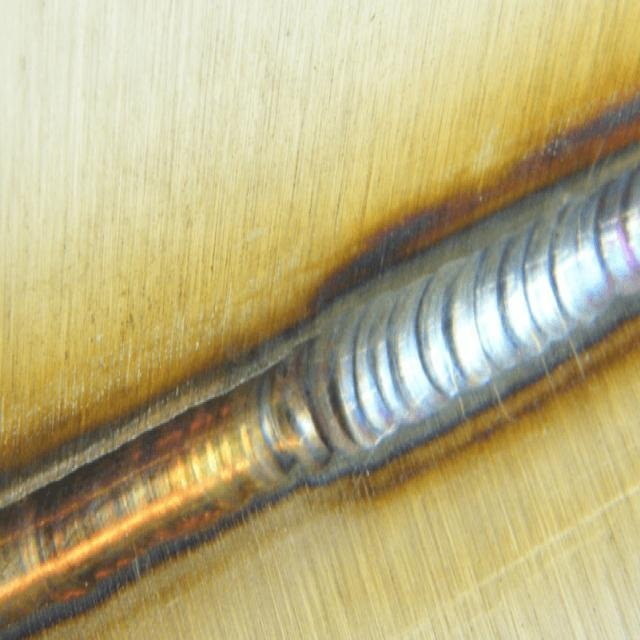


image 1/1 /root/.cache/kagglehub/datasets/sukmaadhiwijaya/welding-defect-object-detection/versions/2/The Welding Defect Dataset/The Welding Defect Dataset/test/images/Good-Welding-images_23_jpeg_jpg.rf.fdf50352e3c124ff6edab3e96257a040.jpg: 640x640 (no detections), 37.1ms
Speed: 2.3ms preprocess, 37.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


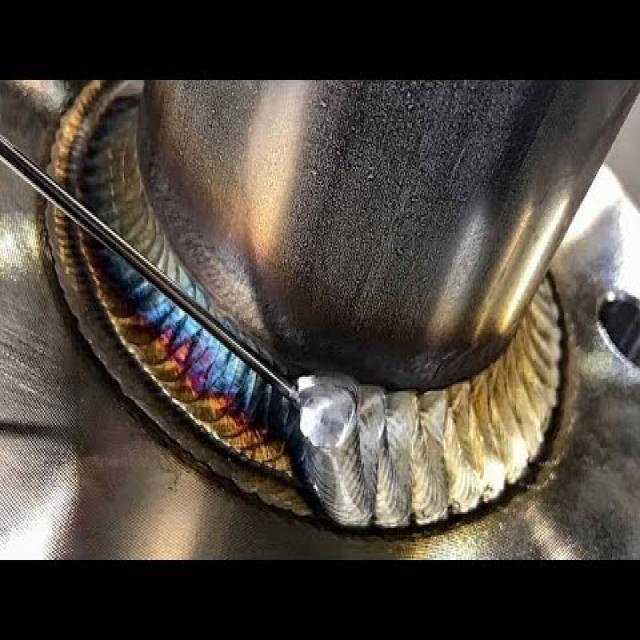


image 1/1 /root/.cache/kagglehub/datasets/sukmaadhiwijaya/welding-defect-object-detection/versions/2/The Welding Defect Dataset/The Welding Defect Dataset/test/images/SampleV2_1_mp4-60_jpg.rf.40f4a4094130e65b1a801b49fefc5d01.jpg: 640x640 5 Bad Welds, 4 Good Welds, 37.1ms
Speed: 2.0ms preprocess, 37.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


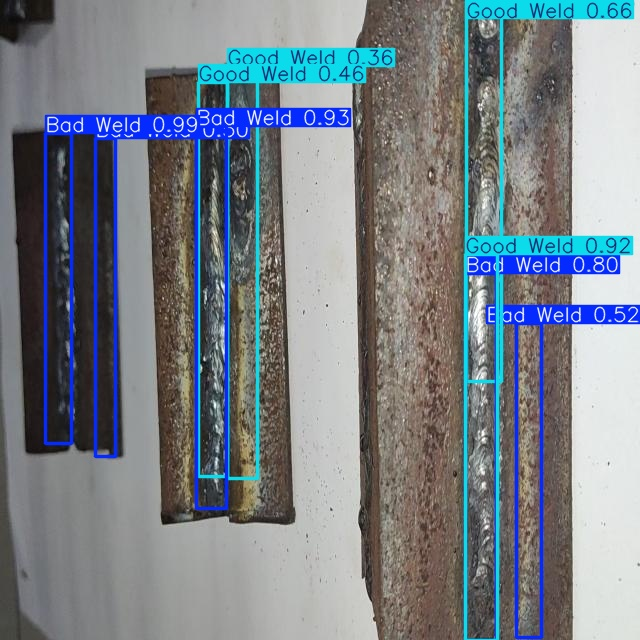


image 1/1 /root/.cache/kagglehub/datasets/sukmaadhiwijaya/welding-defect-object-detection/versions/2/The Welding Defect Dataset/The Welding Defect Dataset/test/images/good_weld_vid104_jpeg_jpg.rf.892dcfa6c4ff7737002a45507ebace2b.jpg: 640x640 1 Bad Weld, 36.7ms
Speed: 2.1ms preprocess, 36.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


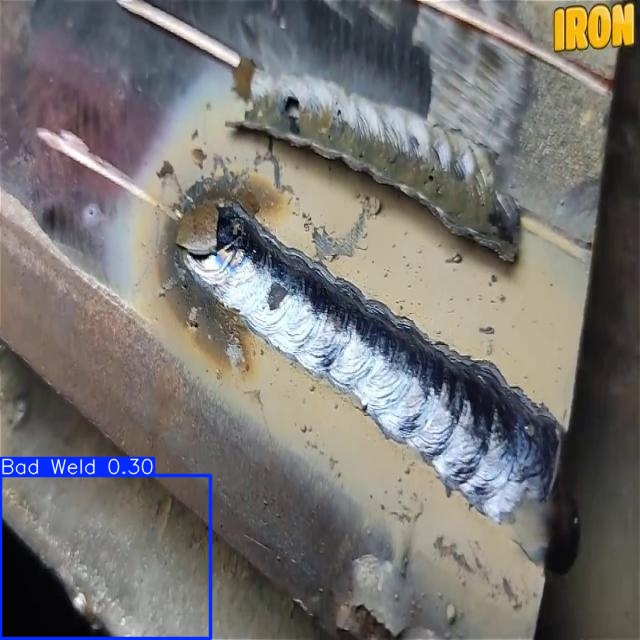


image 1/1 /root/.cache/kagglehub/datasets/sukmaadhiwijaya/welding-defect-object-detection/versions/2/The Welding Defect Dataset/The Welding Defect Dataset/test/images/Spatters-welding-images_30_jpeg_jpg.rf.ac1f61755f14395f6e5da156c7fd043f.jpg: 640x640 3 Bad Welds, 1 Defect, 26.2ms
Speed: 2.0ms preprocess, 26.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


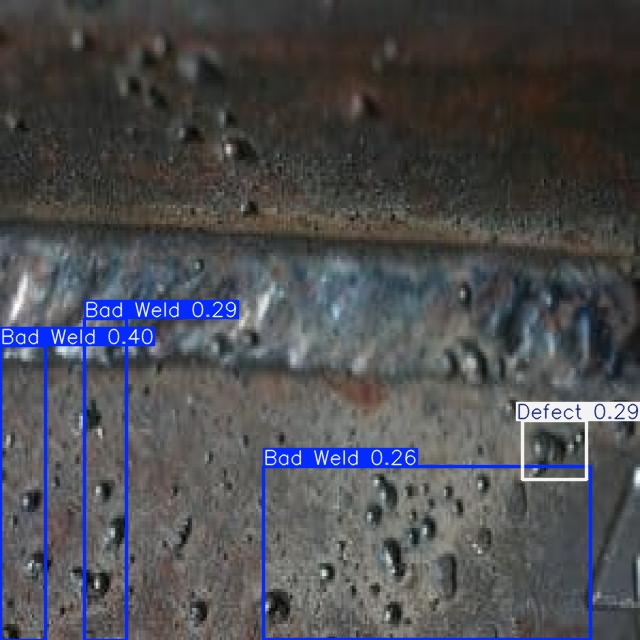

Displaying results from model trained on version 2 with augmentation:

image 1/1 /root/.cache/kagglehub/datasets/sukmaadhiwijaya/welding-defect-object-detection/versions/2/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/good_weld_vid274_jpeg.rf.b6f11d0f012275ef3823e747c05bb460.jpg: 640x640 5 Good Welds, 25.5ms
Speed: 2.0ms preprocess, 25.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


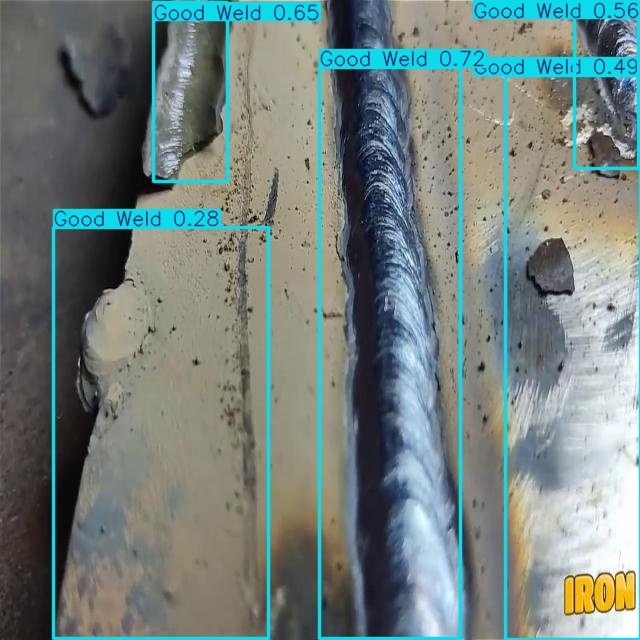


image 1/1 /root/.cache/kagglehub/datasets/sukmaadhiwijaya/welding-defect-object-detection/versions/2/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/Good-Welding-images_33_jpeg_jpg.rf.782ccc0dfca926b946a6b664dd4cacd1.jpg: 640x640 3 Good Welds, 25.9ms
Speed: 2.1ms preprocess, 25.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


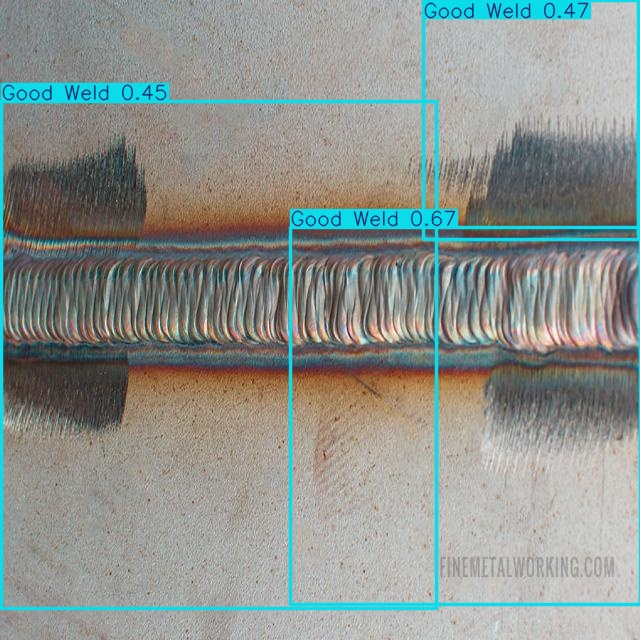


image 1/1 /root/.cache/kagglehub/datasets/sukmaadhiwijaya/welding-defect-object-detection/versions/2/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/good_weld_vid634_jpeg_jpg.rf.9b7bc6b6e69b54eb707c9bab8857b7a1.jpg: 640x640 3 Good Welds, 24.5ms
Speed: 2.0ms preprocess, 24.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)


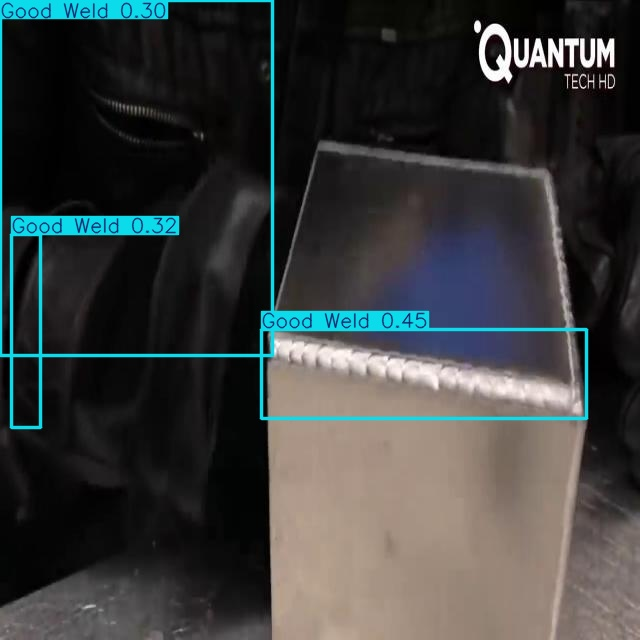


image 1/1 /root/.cache/kagglehub/datasets/sukmaadhiwijaya/welding-defect-object-detection/versions/2/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/Spatters-welding-images_30_jpeg_jpg.rf.ac1f61755f14395f6e5da156c7fd043f.jpg: 640x640 1 Good Weld, 24.3ms
Speed: 1.9ms preprocess, 24.3ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)


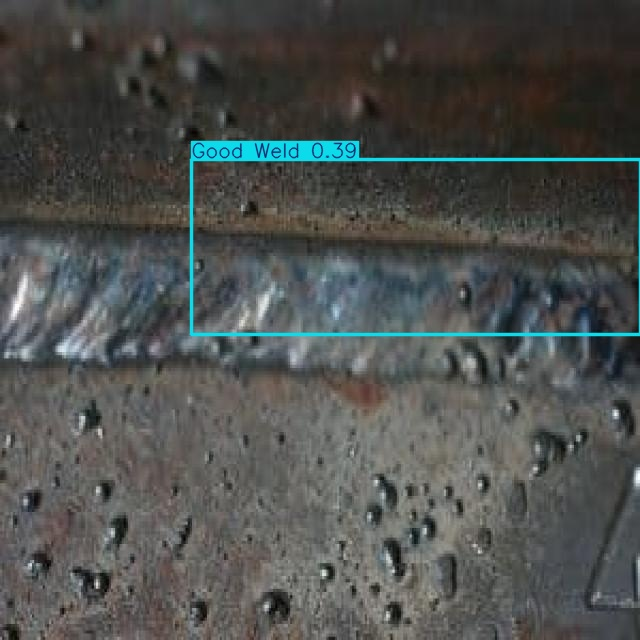


image 1/1 /root/.cache/kagglehub/datasets/sukmaadhiwijaya/welding-defect-object-detection/versions/2/The Welding Defect Dataset - v2/The Welding Defect Dataset - v2/test/images/good_weld_vid1762_jpeg.rf.92508865967a0204f5b78457d8131ac6.jpg: 640x640 2 Good Welds, 23.8ms
Speed: 1.9ms preprocess, 23.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


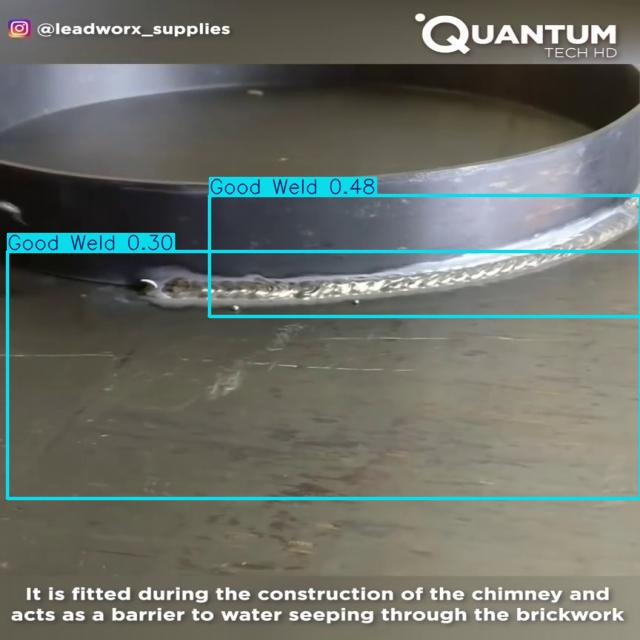

In [21]:
# Evaluate the model and display results
def display_results(model, img_dir, num_images=5):
    images = os.listdir(img_dir)
    sample_images = random.sample(images, num_images)
    save_dir = 'runs/detect/exp'
    os.makedirs(save_dir, exist_ok=True)

    for image_name in sample_images:
        image_path = os.path.join(img_dir, image_name)
        results = model(image_path)
        for result in results:
            result.plot(save=True, filename=os.path.join(save_dir, os.path.basename(result.path)))
            result_image_path = os.path.join(save_dir, os.path.basename(result.path))
            display(Image(filename=result_image_path))

print("Displaying results from model trained on version 1 with augmentation:")
display_results(model_v1, os.path.join(v1_dir, 'test/images'))

print("Displaying results from model trained on version 2 with augmentation:")
display_results(model_v2, os.path.join(v2_dir, 'test/images'))